# CALMS21 minimal example

In [16]:
%config InlineBackend.figure_formats = ['svg']
%matplotlib inline

In [1]:
from automated_scoring.config import cfg
from automated_scoring.io import load_dataset
from automated_scoring.features import DataFrameFeatureExtractor
from automated_scoring.classification.predict import predict
from automated_scoring.classification.visualization import (
    plot_confusion_matrix,
    plot_classification_timeline,
)

from sklearn.ensemble import RandomForestClassifier

In [2]:
cfg.key_keypoints = "keypoints"
cfg.key_timestamp = "timestamps"

cfg.trajectory_keys = ("keypoints", "timestamps")

## 1. Load training dataset and extract features

In [3]:
dataset_train = load_dataset(
    "mice_train",
    directory="../../datasets/CALMS21/train",
    target="dyad",
    background_category="none",
)
dataset_train = dataset_train.exclude_individuals(["intruder"])

dataset_train.category_counts

2025-03-06 15:26:35.228 [WARNING ] Loading categories (attack, investigation, mount, none) from observations file, specify categories argument if incomplete.


{'attack': 14039, 'investigation': 146615, 'mount': 28615, 'none': 318469}

In [4]:
extractor = DataFrameFeatureExtractor(
    cache_directory="feature_cache_mice"
)
extractor.read_yaml("config_file.yaml")

len(extractor.feature_names)

201

In [5]:
X, y = dataset_train.subsample(
    extractor,
    size={category: 1000 for category in dataset_train.categories},
    random_state=1,
)
y = dataset_train.encode(y)

## 2. Fit classification model

In [6]:
classifier = RandomForestClassifier(random_state=1)
classifier.fit(X, y)

RandomForestClassifier(random_state=1)

## 3. Load test dataset and predict

In [7]:
dataset_test = load_dataset(
    "mice_test",
    directory="../../datasets/CALMS21/test",
    target="dyad",
    background_category="none",
)
dataset_test = dataset_test.exclude_individuals(["intruder"])

2025-03-06 15:26:41.186 [WARNING ] Loading categories (attack, investigation, mount, none) from observations file, specify categories argument if incomplete.


In [8]:
result_test = predict(dataset_test, classifier, extractor)

## 4. Visualizations and evaluation

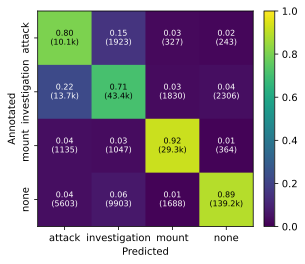

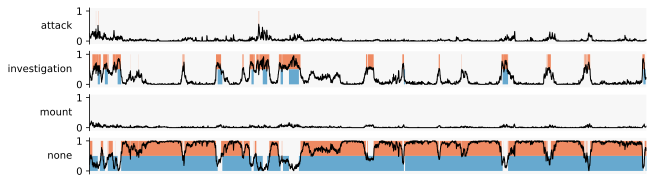

In [18]:
plot_confusion_matrix(
    result_test.y_true_numeric,
    result_test.y_pred_numeric,
    category_labels=result_test.categories,
)

result_group = result_test.classification_results[10]
result_dyad = result_group.classification_results[("resident", "intruder")]

plot_classification_timeline(
    result_dyad.predictions,
    annotations=result_dyad.annotations,
    categories=result_dyad.categories,
    y_proba=result_dyad.y_proba,
    timestamps=result_dyad.timestamps,
)

Compute the F1 score for each category on the per-frame (timestamp) level:

In [10]:
result_test.f1_score("timestamp")

attack           0.468806
investigation    0.738400
mount            0.901669
none             0.932623
Name: timestamp, dtype: float64

This is also available for two other levels, i.e., annotation and prediction intervals.

- when computing scores on prediction intervals, the category of the ground-truth interval with maximum overlap is considered as the true category
- when computing scores on annotation intervals, the category of the predicted interval with maximum overlap is considered as the predicted category

With this in mind, the F1 score of predictions is related to the precision of predicted intervals, whereas the F1 score of annotations is related to the recall of annotated intervals.

In [11]:
result_test.f1_score("annotation")

attack           0.494450
investigation    0.684685
mount            0.822115
none             0.849611
Name: annotation, dtype: float64

In [12]:
result_test.f1_score("prediction")

attack           0.274927
investigation    0.532850
mount            0.480562
none             0.539296
Name: prediction, dtype: float64

And made available as a summary:

In [13]:
result_test.score()

,attack,investigation,mount,none
timestamp,0.468806,0.738400,0.901669,0.932623
annotation,0.494450,0.684685,0.822115,0.849611
prediction,0.274927,0.532850,0.480562,0.539296


We later use the unweighted average of all these scores to find optimal postprocessing hyperparameters.

To compare the predictions with the results of other behavioral classification tools using the CALMS21 dataset, we can compute the macro (unweighted average) F1 score of the behavioral foreground categories ('attack', 'investigation' and 'mount'):

In [14]:
foreground_categories = list(dataset_train.foreground_categories)

macro_f1 = result_test.f1_score("timestamp")[foreground_categories].mean()

macro_f1

np.float64(0.702958669540446)

Note that this is only a simple model that was trained on a very small subset of the available data for demonstration purposes.

In [15]:
result_test.predictions

,start,stop,category,duration,mean_probability,max_probability,true_category,actor,recipient,group
0,0,213,investigation,214.0,0.743131,0.91,investigation,resident,intruder,0
1,214,236,attack,23.0,0.583478,0.69,investigation,resident,intruder,0
2,237,241,investigation,5.0,0.512000,0.52,investigation,resident,intruder,0
3,242,242,attack,1.0,0.540000,0.54,investigation,resident,intruder,0
4,243,247,investigation,5.0,0.498000,0.55,investigation,resident,intruder,0
...,...,...,...,...,...,...,...,...,...,...
11610,11130,11130,investigation,1.0,0.400000,0.40,none,resident,intruder,18
11611,11131,11167,none,37.0,0.667838,0.82,investigation,resident,intruder,18
11612,11168,11183,investigation,16.0,0.575625,0.67,investigation,resident,intruder,18
11613,11184,11184,attack,1.0,0.490000,0.49,investigation,resident,intruder,18
